<a href="https://colab.research.google.com/github/LinaDanilina/recommender-system/blob/master/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install papermill

     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
     |████████████████████████████████| 747kB 18.0MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
%cd drive/My Drive/recommenders

/content/drive/My Drive/recommenders


In [5]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm

from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix


from reco_utils.dataset import movielens
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Pandas version: 0.25.3


In [0]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [7]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)

# Convert to 32-bit in order to reduce memory consumption 
data.loc[:, 'rating'] = data['rating'].astype(np.int32) 

data.head()

100%|██████████| 4.81k/4.81k [00:01<00:00, 4.25kKB/s]


,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(DF = data, **header)

#obtain the sparse matrix 
X = am.gen_affinity_matrix()

The method also returns informations on the sparsness of the dataset and the size of the user/affinity matrix. The former is given by the ratio between the unrated elements and the total number of matrix elements. This is what makes a recommendation task hard: we try to predict 93% of the missing data with only 7% of information!

We split the matrix using the default ration of 0.75, i.e. 75% of the ratings will constitute the train set.

In [0]:
Xtr, Xtst = numpy_stratified_split(X)


The splitter returns:

* Xtr: a matrix containing the train set ratings
* Xtst: a matrix containing the test elements

The model has been implemented as a Tensorflow (TF) class. TF does not support probabilistic models natively, so the implementation of the algorithm has a different structure than the one you may be used to see in popular supervised models. The class has been implemented in such a way that the TF session is hidden inside the fit() method and no explicit call is needed. The algorithm operates in three different steps:

* Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. Other parameters can be optionally tweaked for experimentation and to achieve better performance, as explained in the RBM Deep Dive section.

* Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained only on the training set, the test set is used to display the generalization accuracy of the trained model, useful to have an idea of how to fix the hyper parameters.

* Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined score. The prediction is then returned in a dataframe format ready to be analysed and deployed.

In [10]:
#First we initialize the model class
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU d

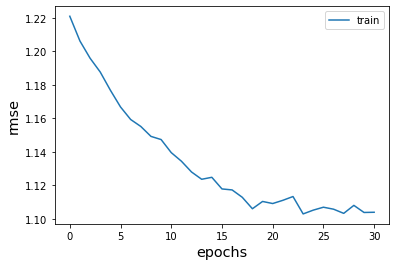

In [11]:
#Model Fit
train_time= model.fit(Xtr, Xtst)


During training, we can optionlly evauate the root mean squared error to have an idea of how the learning is proceeding. We would generally like to see this quantity decreasing as a function of the learning epochs. To visualise this choose with_metrics = True in the RBM() model function.

Once the model has been trained, we can predict new ratings on the test set.

In [0]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k, test_time =  model.recommend_k_items(Xtst)

In [0]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [14]:
top_k_df.head(10)

,userID,movieID,prediction
0,1,100,4.766154
1,1,65,4.718302
2,1,129,4.731462
3,1,99,4.740690
4,1,1104,4.912594
5,1,1177,4.731425
6,1,1418,4.751817
7,1,1427,4.745284
8,1,1514,4.711623
9,1,1546,4.857791


In [0]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [16]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df,
    data_pred =top_k_df,
    time_train=train_time,
    time_test =test_time,
    K =10)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,Train time (s),Test time (s)
0,mv 100k,10,0.142198,0.412087,0.338388,0.213493,11.194315,0.530741
